# Gaia scanning law

The Gaia telescope operates by repeatedly observing stars through two different field of views (preceding and following) separated by the basic angle, 106.5 degrees. It is rotating at a constant rate of 1 degrees per minute (6 hour period), and the axis of rotation precessed around the Sun-to-Earth axis with an average period of 63 days.

<div id="muteYouTubeVideoPlayer"></div>
<script async src="https://www.youtube.com/iframe_api"></script>
<script>
 function onYouTubeIframeAPIReady() {
  var player;
  player = new YT.Player('muteYouTubeVideoPlayer', {
    videoId: 'BnFyzZGWuYs', // YouTube Video ID
    width: 560,               // Player width (in px)
    height: 316,              // Player height (in px)
    playerVars: {
      autoplay: 0,        // Auto-play the video on load
      controls: 1,        // Show pause/play buttons in player
      showinfo: 0,        // Hide the video title
      modestbranding: 1,  // Hide the Youtube Logo
      loop: 1,            // Run the video in a loop
      fs: 0,              // Hide the full screen button
      cc_load_policy: 0, // Hide closed captions
      iv_load_policy: 3,  // Hide the Video Annotations
      autohide: 0,         // Hide video controls when playing
      start: 46
    },
    events: {
      onReady: function(e) {
        e.target.mute();
      }
    }
  });
 }
//https://stackoverflow.com/questions/35044594/youtube-how-to-present-embed-video-with-sound-muted/41045251#41045251
</script>


The scanning law specifies this scanning pattern by a time-series of the reference position of each FoV. With a scanning law, then, we can ask when a given position on the sky would have been observed through each FoV of the Gaia telescope. This is what gaiaunlimited's GaiaScanningLaw class provides.

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from tqdm import tqdm
import healpy as hp
import numpy as np
plt.style.use('notebook')
# gaiaunlimited imports
from gaiaunlimited import utils
from gaiaunlimited.scanninglaw import GaiaScanningLaw

There are two key ingredients to specify the Gaia scanning law:

1. version: FoV time-series, i.e., the version of the scanning law.
2. gaplist: Gaia has gaps in the data-taking that are different for different kind of samples. This specifies which list of gaps to use. 

When you load a version for the first time, gaiaunlimited will download the large scanning law data for that version and save it as pickled pandas DataFrame in GAIAUNLIMITED_DATADIR (`~/.gaiaunlimited` by default) as `<version>.pkl`. It will also cache KDTrees of each FoV pointings in the same directory. Normally, this only has to happen once. 

In [2]:
sl = GaiaScanningLaw('dr3_nominal')
sl

GaiaScanningLaw(version='dr3_nominal', gaplist='dr3/Astrometry')

To query the scanning law, run `query` method with (ra, dec) in degrees as arguments. You get a tuple of numpy arrays containing times that the position was scanned by the preceding and following FoVs.

In [3]:
cc = utils.get_healpix_centers(0)
ra_deg, dec_deg = cc.ra[0].deg, cc.dec[0].deg
t1, t2 = sl.query(ra_deg, dec_deg)

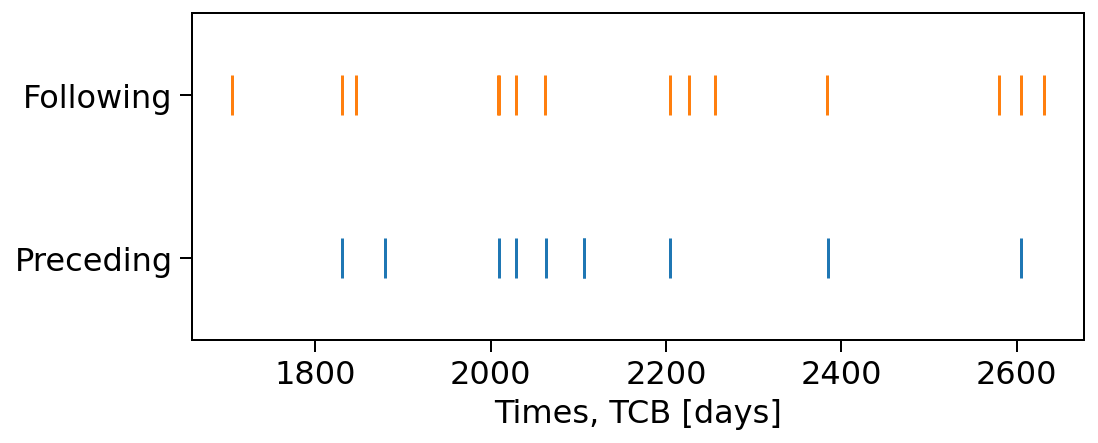

In [4]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(t1, [0]*len(t1), '|', ms=20, mew=1.5)
ax.plot(t2, [1]*len(t2), '|', ms=20, mew=1.5)
ax.set(xlabel='Times, TCB [days]', ylim=(-0.5,1.5))
ax.set_yticks([0,1], ['Preceding','Following']);

If we are only interested in the total number of scans, we can use set `count_only=True`.

Below, we examine the map of the number of scan by repeatedly querying the centers of HEAL order 6.

In [5]:
def get_totaln(*args):
    return sum(sl.query(*args, count_only=True))
cc = utils.get_healpix_centers(6)
result = [get_totaln(*args) for args in zip(tqdm(cc.ra.deg), cc.dec.deg)]

100%|██████████| 49152/49152 [00:17<00:00, 2866.66it/s]


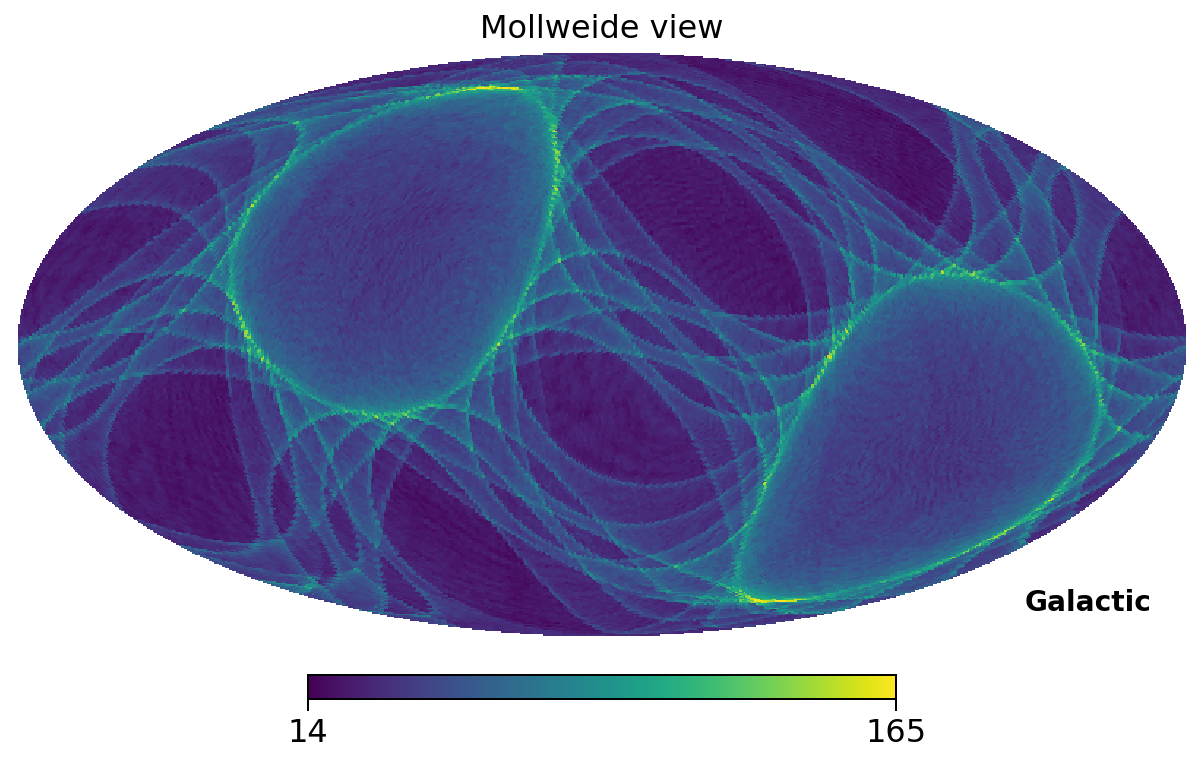

In [6]:
hp.mollview(np.array(result), coord='eg')

## Versions available

Currently, there are two different versions of the scanning law available:

- `dr3_nominal`: The nominal scanning law provided by and available on the [Gaia Archive](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_auxiliary_tables/ssec_dm_commanded_scan_law.html). The actual attitude could deviate from this by up to about 30 arcseconds.
- `dr2_cog3`: The improved scanning law covering DR2 period by [Boubert et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.2954B/abstract). They use the transit-level data from DR2's epoch photometry of variable stars to model the deviations from the nominal. Please refer to the linked publication for more details and cite this work if you make use of this data.